In [1]:
import tensorflow_data_validation as tfdv

from aif360.datasets import StandardDataset
import numpy as np
import pandas as pd
import experiment_util as util
import models
import random

%matplotlib ipympl
%matplotlib inline

import matplotlib.pyplot as plt
import plot_util as putil
import numpy as np

np.random.seed(0)
random.seed(0)

pip install 'aif360[LawSchoolGPA]'


Load datasets, modify it for the experiment and use Framework to examine the dataset.

In [2]:
raw_df=pd.read_csv("../Datasets/Research/OULAD/studentInfo.csv",index_col=2)

In [9]:
df=raw_df.copy()

In [10]:
stats = tfdv.generate_statistics_from_dataframe(df)
tfdv.visualize_statistics(stats)

Tensorflow Data Validation has flag **num_of_prev_attempts** feature as feature with significant amount of missing value. However, in the context of the dataset, those 0 values do not represent missing values.

In [11]:
df=df.dropna()
df=df.reset_index()

df=df.drop(["id_student"],axis=1)
df["final_result"]=df["final_result"].replace(['Distinction','Withdrawn'],['Pass','Fail'])
#unifiying Distinction and Withdrawn label to simplify the dataset task (as well as make different datasets comparable)

In [16]:
folds_index=np.array_split(df.sample(frac=1).index,5)
eval=util.evaluation(df,"gender","final_result","M",folds_index)
result=pd.DataFrame([],columns=util.column)
result.columns.name="Bank"
result

Bank,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference


Scikit-learn data preprocessing

In [17]:
numeric_feautre_names=df.select_dtypes(include=["number"]).columns
categorical_feature_names=df.select_dtypes(include=["object_"]).columns

pre_df=df.copy()

for nc in numeric_feautre_names:
    pre_df[nc]=util.min_max_noramlize(pre_df[nc])   

for cc in categorical_feature_names:
    pre_df[cc]=pd.factorize(pre_df[cc])[0]

In [18]:
result=util.append_Series(result,eval.cross_validation("Random Forest",models.RandomForest,pre_df))
result

Bank,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,0.010865,0.032691,-0.043096,0.043096,-0.032691,0.042391,-0.042391,-0.026866,0.014241,0.026866,0.043096,0.578807


In [19]:
result=util.append_Series(result,eval.cross_validation("Neural Network",models.NeuralNetwork,pre_df))
result

Bank,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,0.010865,0.032691,-0.043096,0.043096,-0.032691,0.042391,-0.042391,-0.026866,0.014241,0.026866,0.043096,0.578807
Neural Network,0.000059,0.081901,-0.053416,0.053416,-0.081901,0.071307,-0.071307,-0.010536,0.022074,0.010536,0.053416,0.595833


In [20]:
result=util.append_Series(result,eval.cross_validation("Gradient Boosting",models.GradientBoost,pre_df))
result

Bank,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,0.010865,0.032691,-0.043096,0.043096,-0.032691,0.042391,-0.042391,-0.026866,0.014241,0.026866,0.043096,0.578807
Neural Network,0.000059,0.081901,-0.053416,0.053416,-0.081901,0.071307,-0.071307,-0.010536,0.022074,0.010536,0.053416,0.595833
Gradient Boosting,-0.000611,0.079404,-0.061584,0.061584,-0.079404,0.076522,-0.076522,-0.005254,0.014373,0.005254,0.061584,0.624198


Scikit-learn models with DisparateImpactRemover from AIF360 preprocessing

In [22]:
raw_dataset=StandardDataset(df=df, label_name="final_result",
                                    favorable_classes=["Pass"],
                                    scores_name="",
                                    protected_attribute_names=['gender'],
                                    privileged_classes=[["M"]],
                                    categorical_features=["code_module","code_presentation","region","highest_education","imd_band","age_band","disability"])

In [23]:
result=util.append_Series(result,eval.cross_validation("Random Forest (DI)",models.DI_RandomForest,raw_dataset))
result

Bank,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,0.010865,0.032691,-0.043096,0.043096,-0.032691,0.042391,-0.042391,-0.026866,0.014241,0.026866,0.043096,0.578807
Neural Network,0.000059,0.081901,-0.053416,0.053416,-0.081901,0.071307,-0.071307,-0.010536,0.022074,0.010536,0.053416,0.595833
Gradient Boosting,-0.000611,0.079404,-0.061584,0.061584,-0.079404,0.076522,-0.076522,-0.005254,0.014373,0.005254,0.061584,0.624198
Random Forest (DI),0.007244,-0.041118,0.038329,-0.038329,0.041118,-0.044390,0.044390,0.017465,-0.022793,-0.017465,-0.038329,0.586144


In [24]:
result=util.append_Series(result,eval.cross_validation("Neural Network (DI)",models.DI_NeuralNetwork,raw_dataset))
result

Bank,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,0.010865,0.032691,-0.043096,0.043096,-0.032691,0.042391,-0.042391,-0.026866,0.014241,0.026866,0.043096,0.578807
Neural Network,0.000059,0.081901,-0.053416,0.053416,-0.081901,0.071307,-0.071307,-0.010536,0.022074,0.010536,0.053416,0.595833
Gradient Boosting,-0.000611,0.079404,-0.061584,0.061584,-0.079404,0.076522,-0.076522,-0.005254,0.014373,0.005254,0.061584,0.624198
Random Forest (DI),0.007244,-0.041118,0.038329,-0.038329,0.041118,-0.044390,0.044390,0.017465,-0.022793,-0.017465,-0.038329,0.586144
Neural Network (DI),0.027826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-0.027826,NaN,0.000000,0.534496


The framework output NaN is due to the Neural Network model with Disparate Impact Remover preprocessing will only output Negative predictions.

In [25]:
result=util.append_Series(result,eval.cross_validation("Gradient Boosting (DI)",models.DI_GradientBoost,raw_dataset))
result

Bank,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,0.010865,0.032691,-0.043096,0.043096,-0.032691,0.042391,-0.042391,-0.026866,0.014241,0.026866,0.043096,0.578807
Neural Network,0.000059,0.081901,-0.053416,0.053416,-0.081901,0.071307,-0.071307,-0.010536,0.022074,0.010536,0.053416,0.595833
Gradient Boosting,-0.000611,0.079404,-0.061584,0.061584,-0.079404,0.076522,-0.076522,-0.005254,0.014373,0.005254,0.061584,0.624198
Random Forest (DI),0.007244,-0.041118,0.038329,-0.038329,0.041118,-0.044390,0.044390,0.017465,-0.022793,-0.017465,-0.038329,0.586144
Neural Network (DI),0.027826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-0.027826,NaN,0.000000,0.534496
Gradient Boosting (DI),0.001484,-0.056605,0.068328,-0.068328,0.056605,-0.068807,0.068807,0.013633,-0.008923,-0.013633,-0.068328,0.625501


Since the bias evalutation metrics of Neutral Network with Disparate Impact is invalid, those result will be removed from the analysis of the experiment result

In [26]:
result=result.drop(["Neural Network (DI)"])
result

Bank,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,0.010865,0.032691,-0.043096,0.043096,-0.032691,0.042391,-0.042391,-0.026866,0.014241,0.026866,0.043096,0.578807
Neural Network,0.000059,0.081901,-0.053416,0.053416,-0.081901,0.071307,-0.071307,-0.010536,0.022074,0.010536,0.053416,0.595833
Gradient Boosting,-0.000611,0.079404,-0.061584,0.061584,-0.079404,0.076522,-0.076522,-0.005254,0.014373,0.005254,0.061584,0.624198
Random Forest (DI),0.007244,-0.041118,0.038329,-0.038329,0.041118,-0.044390,0.044390,0.017465,-0.022793,-0.017465,-0.038329,0.586144
Gradient Boosting (DI),0.001484,-0.056605,0.068328,-0.068328,0.056605,-0.068807,0.068807,0.013633,-0.008923,-0.013633,-0.068328,0.625501


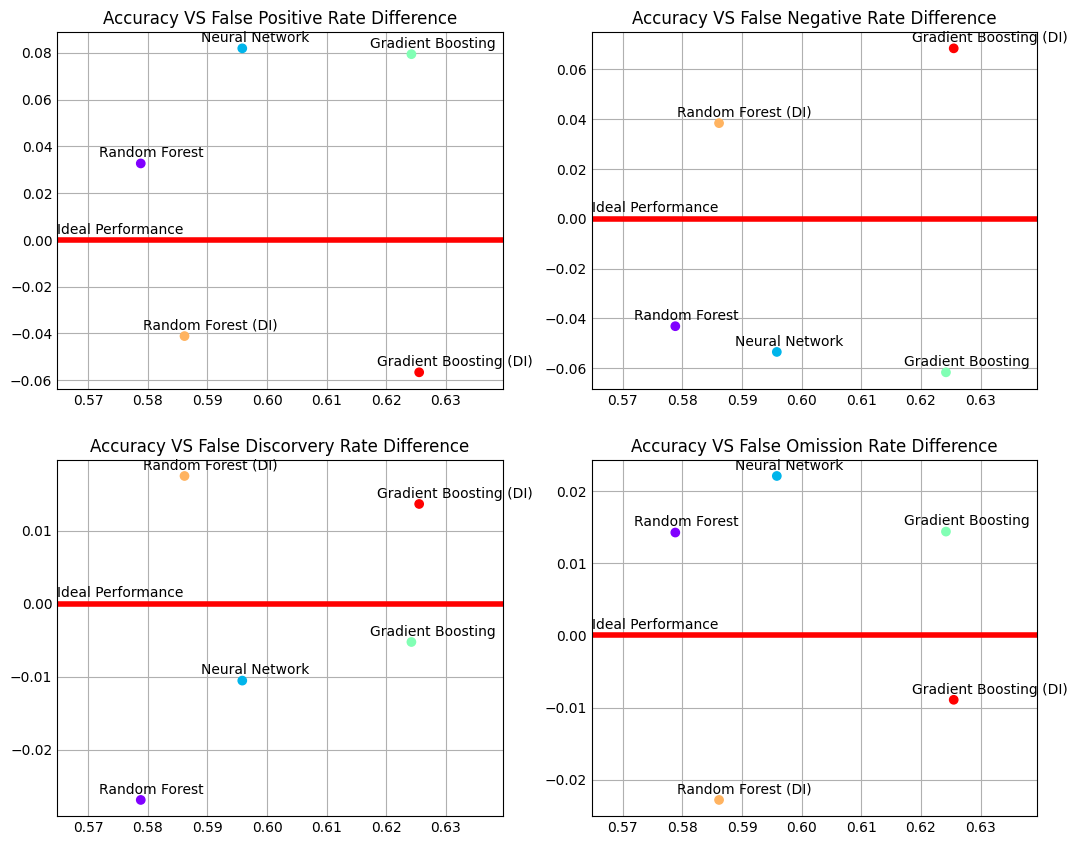

In [27]:
%matplotlib ipympl
%matplotlib inline

plt.style.use('_mpl-gallery')


# plot
fig, ax = plt.subplots(2,2,figsize=(10,8))

putil.plot_scatter(ax[0][0],result["Accuracy"],result["FPR Difference"],"Accuracy VS False Positive Rate Difference",result.index)
putil.plot_scatter(ax[0][1],result["Accuracy"],result["FNR Difference"],"Accuracy VS False Negative Rate Difference",result.index)
putil.plot_scatter(ax[1][0],result["Accuracy"],result["FDR Difference"],"Accuracy VS False Discorvery Rate Difference",result.index)
putil.plot_scatter(ax[1][1],result["Accuracy"],result["FOR Difference"],"Accuracy VS False Omission Rate Difference",result.index)

plt.show()